In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
from pandas.core.dtypes.common import is_numeric_dtype
from sklearn.preprocessing import MinMaxScaler

In [140]:
DATA_FOLDER = 'dataset'
DATASET = os.path.join(DATA_FOLDER, 'preprocessed_df.csv')
OUTLIERS_LABELLED = os.path.join(DATA_FOLDER, 'outliers_labelled.csv')
NEW_DATASET = os.path.join(DATA_FOLDER, 'final_dataset.csv')

In [141]:
df = pd.read_csv(DATASET)
numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]
categorical_attr_list = [col for col in df.columns if not is_numeric_dtype(df[col])]

## Preliminary
Check the behaviour of each OD method on the dataset

In [145]:
# Redefine some stuff of used OD classes
# to obtain code continuity
from sklearn.neighbors import LocalOutlierFactor
from pyod.models.abod import ABOD
from sklearn.ensemble import IsolationForest

class MyLOF(LocalOutlierFactor):
    name = "LOF"

    @property
    def scores(self): return self.negative_outlier_factor_

class MyABOD(ABOD):
    name = "ABOD"

    @property
    def scores(self): return self.decision_scores_

class MyISFO(IsolationForest):
    name = "ISFO"

    def fit(self, X):
        self._train_samp = X
        return super().fit(X)
    
    @property
    def scores(self): return self.score_samples(self._train_samp)

For each method finds the top `p%` outliers

In [186]:
p = 0.01
methods = [MyLOF, MyABOD, MyISFO]
params = [dict(n_jobs=-1), dict(), dict(n_jobs=-1)] # Parameters of the estimators
# The sub-samples in which the dataset is divided
# Currently the OD is performed on each element of (vocal_channel, sex) product category
locality_areas = []
for vc in ["song", "speech"]:
    for s in ["M","F"]:
        locality_areas.append(dict(vocal_channel=vc, sex=s))

scores = []
for meth, pars in zip(methods, params):
    for locality in locality_areas:
        mask = np.array([(df[key] == val).values for key, val in locality.items()]).all(axis=0)
        subsamp = MinMaxScaler().fit_transform( df.loc[mask][numerical_attr_list].values )
        outlier_detector = meth(**pars)
        outlier_detector.fit(subsamp)
        df.loc[mask, f"{meth.name}_score"] = outlier_detector.scores
        bad_kids = np.linspace(0,1, np.sum(mask))[np.argsort(outlier_detector.scores)] > 1-p
        df.loc[mask, f"is_{meth.name}_outlier"] = bad_kids

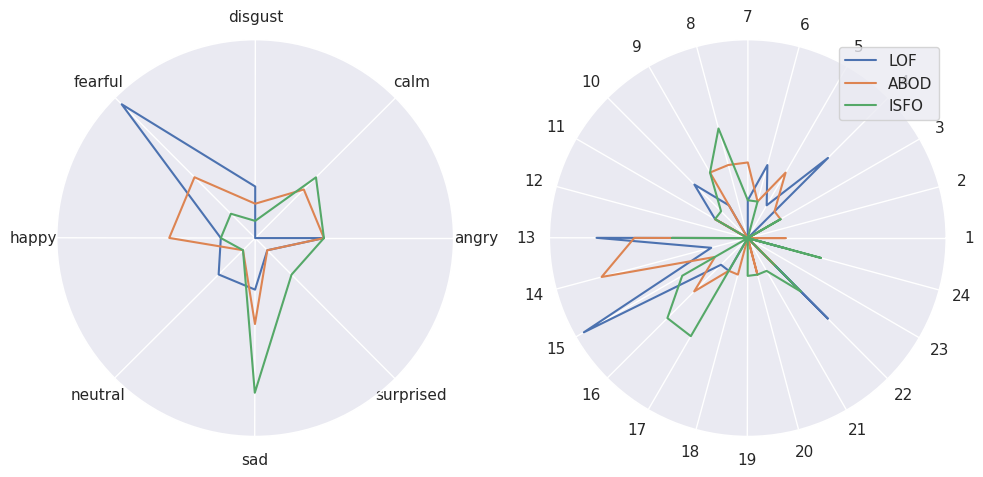

In [187]:
def plot_polar_closed(items, r, ax, **kwargs):
    items = list(items)
    asort = np.argsort(items)

    items = np.array(items)[asort]
    r = np.array(list(r))[asort]

    theta = np.linspace(0, 6.28, len(items), endpoint=False)

    theta = np.append(theta, theta[0])
    r = np.append(r, r[0])

    ax.plot(theta, r, **kwargs)
    ax.set_xticks(theta[:-1], items)
    ax.set_rticks([])


fig, axes = plt.subplots(1,2, figsize=(10,8), subplot_kw={'projection': 'polar'})
for i, cat in enumerate(["emotion", "actor"]):
    for meth in methods:
        outlying_items, counts_num = np.unique(df.loc[df[f"is_{ meth.name}_outlier"], cat], return_counts=True)
        all_items = np.unique(df[cat])

        if cat == "actor":
            outlying_items = [int(act_name.split("_")[1]) for act_name in outlying_items]
            all_items = [int(act_name.split("_")[1]) for act_name in all_items]

        counts = {c:0 for c in np.unique(all_items)}
        for outlying_item, c in zip(outlying_items, counts_num):
            counts[outlying_item] = c

        plot_polar_closed(counts.keys(), counts.values(), axes[i], label=meth.name)

axes[i].legend()

## LOF

In [15]:
df_sex_m = df[df['sex'] == 'M']
df_sex_f = df[df['sex'] == 'F']

df_sex_m = df_sex_m[numerical_attr_list]
df_sex_f = df_sex_f[numerical_attr_list]

In [16]:
scaler = MinMaxScaler()
X_sex_m = scaler.fit_transform(df_sex_m)
X_sex_f = scaler.fit_transform(df_sex_f)

In [18]:
from sklearn.decomposition import PCA

def eigenvalues_plot(X):
    pca = PCA()
    pca.fit(X)
    eigenvalues = pca.explained_variance_

    variance = eigenvalues / np.sum(eigenvalues)

    # 50 eigenvalues
    components = np.arange(1, 51)
    variance = variance[:50]

    plt.plot(components, variance, 'bo-')
    plt.xlabel('Principal components')
    plt.ylabel('Variance')
    plt.grid(True)
    plt.show()

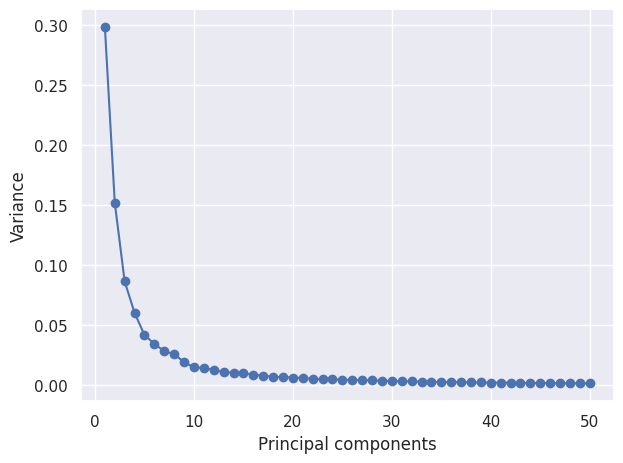

In [19]:
eigenvalues_plot(X_sex_m)

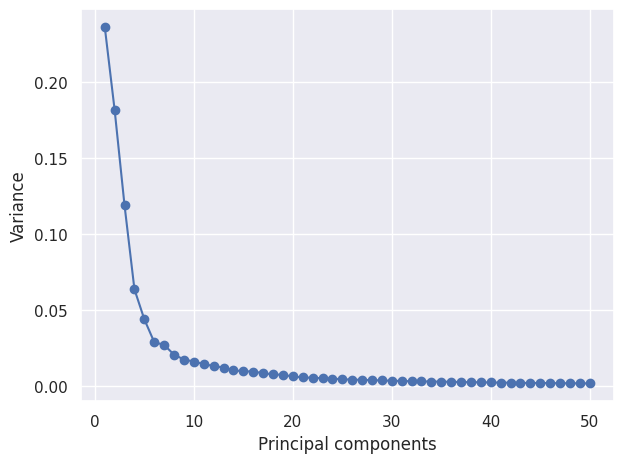

In [21]:
eigenvalues_plot(X_sex_f)

In [22]:
pca = PCA(n_components=5)
X_sex_m = pca.fit_transform(X_sex_m)
X_sex_f = pca.fit_transform(X_sex_f)

In [23]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_jobs=-1)
outliers = clf.fit_predict(X_sex_m)

In [24]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([   8, 1240]))

In [25]:
df_sex_m['outlier_score'] = clf.negative_outlier_factor_

is_outlier = np.where(outliers == 1, False, True)
df_sex_m['is_outlier'] = is_outlier

In [26]:
clf = LocalOutlierFactor(n_jobs=-1)
outliers = clf.fit_predict(X_sex_f)

In [27]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([   5, 1199]))

In [28]:
df_sex_f['outlier_score'] = clf.negative_outlier_factor_

is_outlier = np.where(outliers == 1, False, True)
df_sex_f['is_outlier'] = is_outlier

In [32]:
df_store = df.copy()
stored_columns = []

In [33]:
df_store['outlier_score_sex_lof'] = df_sex_f['outlier_score'].combine_first(df_sex_m['outlier_score'])
df_store['is_outlier_sex_lof'] = df_sex_f['is_outlier'].combine_first(df_sex_m['is_outlier'])

stored_columns += ['outlier_score_sex_lof', 'is_outlier_sex_lof']
df_store[['outlier_score_sex_lof', 'is_outlier_sex_lof']]

,outlier_score_sex_lof,is_outlier_sex_lof
0,-1.162781,False
1,-1.038024,False
2,-1.077282,False
3,-1.020366,False
4,-1.081104,False
...,...,...
2447,-0.988517,False
2448,-1.006352,False
2449,-1.010688,False
2450,-1.029463,False


In [34]:
df_speech = df[df['vocal_channel'] == 'speech']
df_song = df[df['vocal_channel'] == 'song']

df_speech = df_speech[numerical_attr_list]
df_song = df_song[numerical_attr_list]

In [35]:
X_speech = scaler.fit_transform(df_speech)
X_song = scaler.fit_transform(df_song)

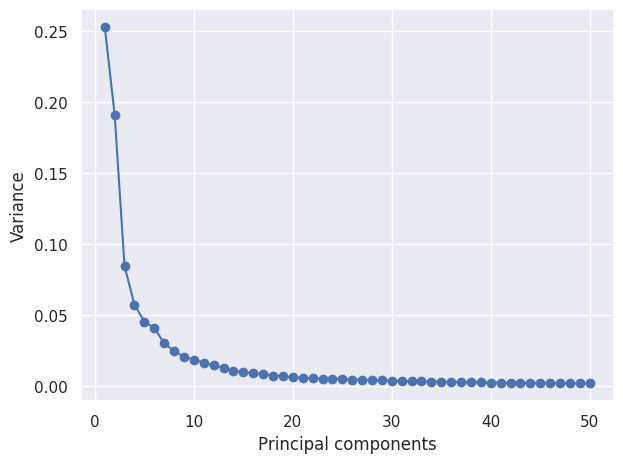

In [36]:
eigenvalues_plot(X_speech)

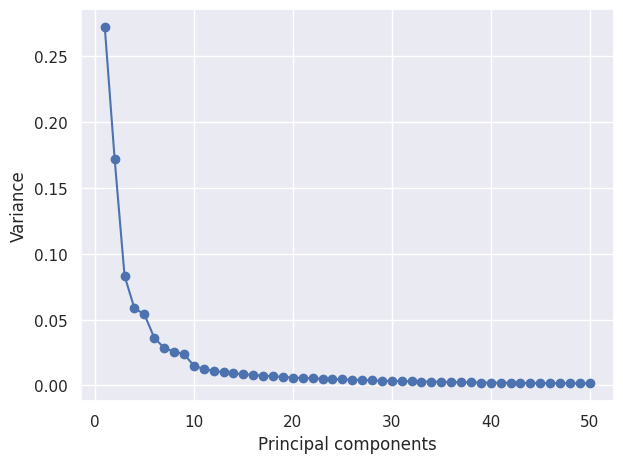

In [37]:
eigenvalues_plot(X_song)

In [38]:
pca = PCA(n_components=5)
X_speech = pca.fit_transform(X_speech)
X_song = pca.fit_transform(X_song)

In [39]:
clf = LocalOutlierFactor(n_jobs=-1)
outliers = clf.fit_predict(X_speech)

In [40]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([   7, 1433]))

In [41]:
df_speech['outlier_score'] = clf.negative_outlier_factor_

is_outlier = np.where(outliers == 1, False, True)
df_speech['is_outlier'] = is_outlier

In [42]:
clf = LocalOutlierFactor(n_jobs=-1)
outliers = clf.fit_predict(X_song)

In [43]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([   8, 1004]))

In [44]:
df_song['outlier_score'] = clf.negative_outlier_factor_

is_outlier = np.where(outliers == 1, False, True)
df_song['is_outlier'] = is_outlier

In [45]:
df_store['outlier_score_vc_lof'] = df_song['outlier_score'].combine_first(df_speech['outlier_score'])
df_store['is_outlier_vc_lof'] = df_song['is_outlier'].combine_first(df_speech['is_outlier'])

stored_columns += ['outlier_score_vc_lof', 'is_outlier_vc_lof']
df_store[['outlier_score_vc_lof', 'is_outlier_vc_lof']]

,outlier_score_vc_lof,is_outlier_vc_lof
0,-1.194877,False
1,-1.080910,False
2,-1.137767,False
3,-1.020084,False
4,-1.069881,False
...,...,...
2447,-1.002921,False
2448,-1.018316,False
2449,-1.029578,False
2450,-1.010099,False


#### now that all outlier scores have been calculated, it is possible to select the top 1%

In [46]:
df_outliers = df_store.loc[(df_store['is_outlier_sex_lof'] == True) | (df_store['is_outlier_vc_lof'] == True)]

In [47]:
scores = df_outliers['outlier_score_sex_lof'] + df_outliers['outlier_score_vc_lof']
scores_vc = df_outliers['outlier_score_vc_lof']
scores_sex = df_outliers['outlier_score_sex_lof']
scores

35     -2.840767
40     -2.642131
235    -2.934473
382    -3.605932
512    -2.670154
515    -2.628191
589    -3.247023
698    -3.821576
832    -3.782131
841    -2.998270
843    -3.169822
903    -2.974453
1176   -2.700363
1283   -2.731851
1390   -3.162692
1756   -2.910177
1757   -3.074575
1877   -2.991210
1878   -2.708619
2210   -2.969700
2287   -2.958662
2392   -4.248103
dtype: float64

In [48]:
# find top 1% outliers
one_percent = int(df.shape[0] / 100)

top1pct_outliers_sex_lof = scores_sex.nsmallest(one_percent)
top1pct_outliers_vc_lof = scores_vc.nsmallest(one_percent)
top1pct_outliers_lof = scores.nsmallest(one_percent)
top1pct_outliers_lof

2392   -4.248103
698    -3.821576
832    -3.782131
382    -3.605932
589    -3.247023
843    -3.169822
1390   -3.162692
1757   -3.074575
841    -2.998270
1877   -2.991210
903    -2.974453
2210   -2.969700
2287   -2.958662
235    -2.934473
1756   -2.910177
35     -2.840767
1283   -2.731851
1878   -2.708619
1176   -2.700363
512    -2.670154
40     -2.642131
515    -2.628191
dtype: float64

## Isolation Forest

In [49]:
df_sex_m = df[df['sex'] == 'M']
df_sex_f = df[df['sex'] == 'F']

df_sex_m = df_sex_m[numerical_attr_list]
df_sex_f = df_sex_f[numerical_attr_list]

In [50]:
X_sex_m = scaler.fit_transform(df_sex_m)
X_sex_f = scaler.fit_transform(df_sex_f)

In [51]:
from sklearn.ensemble import IsolationForest

isfo = IsolationForest(n_jobs=-1)
outliers = isfo.fit_predict(X_sex_m)

In [52]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  46, 1202]))

In [53]:
df_sex_m['outlier_score'] = isfo.score_samples(X_sex_m)

is_outlier = np.where(outliers == 1, False, True)
df_sex_m['is_outlier'] = is_outlier

In [54]:
isfo = IsolationForest(n_jobs=-1)
outliers = isfo.fit_predict(X_sex_f)

In [55]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  48, 1156]))

In [56]:
df_sex_f['outlier_score'] = isfo.score_samples(X_sex_f)

is_outlier = np.where(outliers == 1, False, True)
df_sex_f['is_outlier'] = is_outlier

In [57]:
df_store['outlier_score_sex_isfo'] = df_sex_f['outlier_score'].combine_first(df_sex_m['outlier_score'])
df_store['is_outlier_sex_isfo'] = df_sex_f['is_outlier'].combine_first(df_sex_m['is_outlier'])

stored_columns += ['outlier_score_sex_isfo', 'is_outlier_sex_isfo']
df_store[['outlier_score_sex_isfo', 'is_outlier_sex_isfo']]

,outlier_score_sex_isfo,is_outlier_sex_isfo
0,-0.472210,False
1,-0.421543,False
2,-0.415925,False
3,-0.402881,False
4,-0.405113,False
...,...,...
2447,-0.384855,False
2448,-0.388273,False
2449,-0.402467,False
2450,-0.394011,False


In [58]:
df_speech = df[df['vocal_channel'] == 'speech']
df_song = df[df['vocal_channel'] == 'song']

df_speech = df_speech[numerical_attr_list]
df_song = df_song[numerical_attr_list]

In [59]:
X_speech = scaler.fit_transform(df_speech)
X_song = scaler.fit_transform(df_song)

In [60]:
isfo = IsolationForest(n_jobs=-1)
outliers = isfo.fit_predict(X_speech)

In [61]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  69, 1371]))

In [62]:
df_speech['outlier_score'] = isfo.score_samples(X_speech)

is_outlier = np.where(outliers == 1, False, True)
df_speech['is_outlier'] = is_outlier

In [63]:
isfo = IsolationForest(n_jobs=-1)
outliers = isfo.fit_predict(X_song)

In [64]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([ 46, 966]))

In [65]:
df_song['outlier_score'] = isfo.score_samples(X_song)

is_outlier = np.where(outliers == 1, False, True)
df_song['is_outlier'] = is_outlier

In [66]:
df_store['outlier_score_vc_isfo'] = df_speech['outlier_score'].combine_first(df_song['outlier_score'])
df_store['is_outlier_vc_isfo'] = df_speech['is_outlier'].combine_first(df_song['is_outlier'])

stored_columns += ['outlier_score_vc_isfo', 'is_outlier_vc_isfo']
df_store[['outlier_score_vc_isfo', 'is_outlier_vc_isfo']]

,outlier_score_vc_isfo,is_outlier_vc_isfo
0,-0.464850,False
1,-0.423100,False
2,-0.431190,False
3,-0.435336,False
4,-0.414188,False
...,...,...
2447,-0.415474,False
2448,-0.421597,False
2449,-0.424737,False
2450,-0.430217,False


#### now that all outlier scores have been calculated, it is possible to select the top 1%

In [67]:
df_outliers = df_store.loc[(df_store['is_outlier_sex_isfo'] == True) | (df_store['is_outlier_vc_isfo'] == True)]

In [68]:
scores = df_outliers['outlier_score_sex_isfo'] + df_outliers['outlier_score_vc_isfo']
scores_vc = df_outliers['outlier_score_vc_isfo']
scores_sex = df_outliers['outlier_score_sex_isfo']
scores

32     -1.039716
34     -0.986620
35     -1.192925
40     -0.980239
94     -0.991329
          ...   
2233   -0.987694
2235   -1.019659
2278   -0.982254
2383   -0.970417
2441   -0.975825
Length: 132, dtype: float64

In [69]:
# find top 1% outliers
one_percent = int(df.shape[0] / 100)

top1pct_outliers_sex_isfo = scores_sex.nsmallest(one_percent)
top1pct_outliers_vc_isfo = scores_vc.nsmallest(one_percent)
top1pct_outliers_isfo = scores.nsmallest(one_percent)
top1pct_outliers_isfo

1283   -1.223085
35     -1.192925
1862   -1.178031
563    -1.159888
243    -1.155612
1973   -1.148409
560    -1.146688
561    -1.144660
1704   -1.139051
1757   -1.135388
1801   -1.135198
554    -1.129393
1756   -1.129131
1861   -1.122462
1759   -1.107980
659    -1.103088
1975   -1.100295
657    -1.100053
1177   -1.097605
1966   -1.089676
656    -1.084402
1800   -1.083567
1031   -1.082321
251    -1.079425
dtype: float64

## ABOD

In [70]:
df_sex_m = df[df['sex'] == 'M']
df_sex_f = df[df['sex'] == 'F']

df_sex_m = df_sex_m[numerical_attr_list]
df_sex_f = df_sex_f[numerical_attr_list]

In [71]:
X_sex_m = scaler.fit_transform(df_sex_m)
X_sex_f = scaler.fit_transform(df_sex_f)

In [72]:
from pyod.models.abod import ABOD

abod = ABOD()
outliers = abod.fit_predict(X_sex_m)

/home/djanloo/.virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


In [73]:
np.unique(outliers, return_counts=True)

(array([0, 1]), array([1123,  125]))

In [74]:
df_sex_m['outlier_score'] = abod.decision_scores_

# using ABOD, 1 -> outlier && 0 -> inlier
is_outlier = np.where(outliers == 1, True, False)
df_sex_m['is_outlier'] = is_outlier

In [75]:
abod = ABOD()
outliers = abod.fit_predict(X_sex_f)

/home/djanloo/.virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


In [76]:
np.unique(outliers, return_counts=True)

(array([0, 1]), array([1083,  121]))

In [77]:
df_sex_f['outlier_score'] = abod.decision_scores_

# using ABOD, 1 -> outlier && 0 -> inlier
is_outlier = np.where(outliers == 1, True, False)
df_sex_f['is_outlier'] = is_outlier

In [78]:
df_store['outlier_score_sex_abod'] = df_sex_f['outlier_score'].combine_first(df_sex_m['outlier_score'])
df_store['is_outlier_sex_abod'] = df_sex_f['is_outlier'].combine_first(df_sex_m['is_outlier'])

stored_columns += ['outlier_score_sex_abod', 'is_outlier_sex_abod']
df_store[['outlier_score_sex_abod', 'is_outlier_sex_abod']]

,outlier_score_sex_abod,is_outlier_sex_abod
0,-0.000272,True
1,-0.005159,False
2,-0.025919,False
3,-0.006972,False
4,-0.002715,False
...,...,...
2447,-0.035669,False
2448,-0.017515,False
2449,-0.007905,False
2450,-0.005445,False


In [79]:
df_speech = df[df['vocal_channel'] == 'speech']
df_song = df[df['vocal_channel'] == 'song']

df_speech = df_speech[numerical_attr_list]
df_song = df_song[numerical_attr_list]

In [80]:
X_speech = scaler.fit_transform(df_speech)
X_song = scaler.fit_transform(df_song)

In [81]:
abod = ABOD()
outliers = abod.fit_predict(X_speech)

/home/djanloo/.virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


In [82]:
np.unique(outliers, return_counts=True)

(array([0, 1]), array([1296,  144]))

In [83]:
df_speech['outlier_score'] = abod.decision_scores_

# using ABOD, 1 -> outlier && 0 -> inlier
is_outlier = np.where(outliers == 1, True, False)
df_speech['is_outlier'] = is_outlier

In [84]:
abod = ABOD()
outliers = abod.fit_predict(X_song)

/home/djanloo/.virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


In [85]:
np.unique(outliers, return_counts=True)

(array([0, 1]), array([910, 102]))

In [86]:
df_song['outlier_score'] = abod.decision_scores_

# using ABOD, 1 -> outlier && 0 -> inlier
is_outlier = np.where(outliers == 1, True, False)
df_song['is_outlier'] = is_outlier

In [87]:
df_store['outlier_score_vc_abod'] = df_speech['outlier_score'].combine_first(df_song['outlier_score'])
df_store['is_outlier_vc_abod'] = df_speech['is_outlier'].combine_first(df_song['is_outlier'])

stored_columns += ['outlier_score_vc_abod', 'is_outlier_vc_abod']
df_store[['outlier_score_vc_abod', 'is_outlier_vc_abod']]

,outlier_score_vc_abod,is_outlier_vc_abod
0,-0.002171,False
1,-0.010967,False
2,-0.024170,False
3,-0.011800,False
4,-0.011233,False
...,...,...
2447,-0.022206,False
2448,-0.008860,False
2449,-0.003232,False
2450,-0.004058,False


#### now that all outlier scores have been calculated, it is possible to select the top 1%

In [88]:
df_outliers = df_store.loc[(df_store['is_outlier_sex_abod'] == True) | (df_store['is_outlier_vc_abod'] == True)]

In [89]:
scores = df_outliers['outlier_score_sex_abod'] + df_outliers['outlier_score_vc_abod']
scores_vc = df_outliers['outlier_score_vc_abod']
scores_sex = df_outliers['outlier_score_sex_abod']
scores

0      -0.002443
8      -0.003400
13     -0.005057
17     -0.003363
32     -0.002482
          ...   
2425   -0.003687
2426   -0.002269
2437   -0.002124
2440   -0.002044
2443   -0.002981
Length: 338, dtype: float64

In [90]:
# find top 1% outliers
one_percent = int(df.shape[0] / 100)
# using ABOD the larger the value, the more abnormal the data
top1pct_outliers_sex_abod = scores_sex.nlargest(one_percent)
top1pct_outliers_vc_abod = scores_vc.nlargest(one_percent)
top1pct_outliers_abod = scores.nlargest(one_percent)
top1pct_outliers_abod

2392   -0.000173
841    -0.000336
352    -0.000382
927    -0.000425
2375   -0.000464
1283   -0.000539
292    -0.000589
1738   -0.000590
546    -0.000613
1367   -0.000652
1862   -0.000679
1968   -0.000691
35     -0.000696
1177   -0.000794
698    -0.000809
2336   -0.000814
92     -0.000818
842    -0.000840
361    -0.000907
1982   -0.000917
1878   -0.000924
955    -0.000927
1702   -0.000956
1496   -0.000972
dtype: float64

In [91]:
df_store.to_csv(OUTLIERS_LABELLED, index=False)

## Compare the outliers obtained by the three different methods

In [92]:
display(top1pct_outliers_lof, top1pct_outliers_sex_lof, top1pct_outliers_vc_lof)

2392   -4.248103
698    -3.821576
832    -3.782131
382    -3.605932
589    -3.247023
843    -3.169822
1390   -3.162692
1757   -3.074575
841    -2.998270
1877   -2.991210
903    -2.974453
2210   -2.969700
2287   -2.958662
235    -2.934473
1756   -2.910177
35     -2.840767
1283   -2.731851
1878   -2.708619
1176   -2.700363
512    -2.670154
40     -2.642131
515    -2.628191
dtype: float64

2392   -2.256201
832    -1.855752
382    -1.830512
698    -1.701645
589    -1.668551
1877   -1.654058
35     -1.570689
1176   -1.566009
1878   -1.555408
40     -1.528683
1390   -1.522316
1283   -1.520908
1756   -1.512147
841    -1.494749
2210   -1.417032
903    -1.408687
1757   -1.404175
235    -1.356053
843    -1.350362
2287   -1.248861
512    -1.162863
515    -0.988996
Name: outlier_score_sex_lof, dtype: float64

698    -2.119931
2392   -1.991902
832    -1.926379
843    -1.819460
382    -1.775420
2287   -1.709801
1757   -1.670400
1390   -1.640376
515    -1.639194
589    -1.578472
235    -1.578420
903    -1.565766
2210   -1.552668
512    -1.507292
841    -1.503521
1756   -1.398031
1877   -1.337152
35     -1.270077
1283   -1.210942
1878   -1.153211
1176   -1.134354
40     -1.113448
Name: outlier_score_vc_lof, dtype: float64

In [93]:
display(top1pct_outliers_isfo, top1pct_outliers_sex_isfo, top1pct_outliers_vc_isfo)

1283   -1.223085
35     -1.192925
1862   -1.178031
563    -1.159888
243    -1.155612
1973   -1.148409
560    -1.146688
561    -1.144660
1704   -1.139051
1757   -1.135388
1801   -1.135198
554    -1.129393
1756   -1.129131
1861   -1.122462
1759   -1.107980
659    -1.103088
1975   -1.100295
657    -1.100053
1177   -1.097605
1966   -1.089676
656    -1.084402
1800   -1.083567
1031   -1.082321
251    -1.079425
dtype: float64

1283   -0.616042
35     -0.597365
1801   -0.581586
1862   -0.578059
243    -0.567950
554    -0.565627
1861   -0.564640
560    -0.563104
1704   -0.562897
563    -0.560183
1800   -0.557653
1973   -0.557257
1177   -0.556339
561    -0.554852
657    -0.550535
1756   -0.550194
1802   -0.549830
1757   -0.547309
1031   -0.545464
658    -0.543195
1975   -0.539878
659    -0.539847
555    -0.538589
1759   -0.538353
Name: outlier_score_sex_isfo, dtype: float64

1283   -0.607042
1862   -0.599972
563    -0.599704
35     -0.595560
1973   -0.591152
561    -0.589808
1757   -0.588079
243    -0.587661
560    -0.583584
1756   -0.578937
1704   -0.576154
1759   -0.569626
554    -0.563766
659    -0.563241
1975   -0.560418
1966   -0.560400
1861   -0.557822
241    -0.557793
1702   -0.556087
656    -0.554432
1801   -0.553612
657    -0.549517
248    -0.549376
251    -0.548250
Name: outlier_score_vc_isfo, dtype: float64

In [94]:
display(top1pct_outliers_abod, top1pct_outliers_sex_abod, top1pct_outliers_vc_abod)

2392   -0.000173
841    -0.000336
352    -0.000382
927    -0.000425
2375   -0.000464
1283   -0.000539
292    -0.000589
1738   -0.000590
546    -0.000613
1367   -0.000652
1862   -0.000679
1968   -0.000691
35     -0.000696
1177   -0.000794
698    -0.000809
2336   -0.000814
92     -0.000818
842    -0.000840
361    -0.000907
1982   -0.000917
1878   -0.000924
955    -0.000927
1702   -0.000956
1496   -0.000972
dtype: float64

2392   -0.000081
1177   -0.000109
2383   -0.000116
841    -0.000164
92     -0.000188
1283   -0.000211
2269   -0.000218
546    -0.000223
2375   -0.000239
352    -0.000254
955    -0.000272
0      -0.000272
223    -0.000291
927    -0.000293
292    -0.000325
878    -0.000328
1367   -0.000330
1982   -0.000348
1862   -0.000356
1241   -0.000358
1047   -0.000370
2336   -0.000371
1968   -0.000377
361    -0.000380
Name: outlier_score_sex_abod, dtype: float64

2392   -0.000092
1738   -0.000113
2032   -0.000122
352    -0.000128
927    -0.000132
841    -0.000172
934    -0.000186
2375   -0.000224
698    -0.000230
292    -0.000265
1968   -0.000314
35     -0.000315
1206   -0.000320
1367   -0.000322
1862   -0.000323
1283   -0.000328
2008   -0.000346
2035   -0.000350
614    -0.000356
1861   -0.000381
842    -0.000385
546    -0.000390
1878   -0.000402
923    -0.000403
Name: outlier_score_vc_abod, dtype: float64

In [95]:
df_store[stored_columns]

,outlier_score_sex_lof,is_outlier_sex_lof,outlier_score_vc_lof,is_outlier_vc_lof,outlier_score_sex_isfo,is_outlier_sex_isfo,outlier_score_vc_isfo,is_outlier_vc_isfo,outlier_score_sex_abod,is_outlier_sex_abod,outlier_score_vc_abod,is_outlier_vc_abod
0,-1.162781,False,-1.194877,False,-0.472210,False,-0.464850,False,-0.000272,True,-0.002171,False
1,-1.038024,False,-1.080910,False,-0.421543,False,-0.423100,False,-0.005159,False,-0.010967,False
2,-1.077282,False,-1.137767,False,-0.415925,False,-0.431190,False,-0.025919,False,-0.024170,False
3,-1.020366,False,-1.020084,False,-0.402881,False,-0.435336,False,-0.006972,False,-0.011800,False
4,-1.081104,False,-1.069881,False,-0.405113,False,-0.414188,False,-0.002715,False,-0.011233,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2447,-0.988517,False,-1.002921,False,-0.384855,False,-0.415474,False,-0.035669,False,-0.022206,False
2448,-1.006352,False,-1.018316,False,-0.388273,False,-0.421597,False,-0.017515,False,-0.008860,False
2449,-1.010688,False,-1.029578,False,-0.402467,False,-0.424737,False,-0.007905,False,-0.003232,False
2450,-1.029463,False,-1.010099,False,-0.394011,False,-0.430217,False,-0.005445,False,-0.004058,False


In [96]:
df_store['sum_scores_sex'] = df_store['outlier_score_sex_lof'] + \
                             df_store['outlier_score_sex_isfo'] - \
                             df_store['outlier_score_sex_abod'] # substract because the larger the more abnormal

df_store['sum_scores_vc'] = df_store['outlier_score_vc_lof'] + \
                             df_store['outlier_score_vc_isfo'] - \
                             df_store['outlier_score_vc_abod'] # substract because the larger the more abnormal

top1pct_sum_sex = df_store['sum_scores_sex'].nsmallest(one_percent)
top1pct_sum_vc = df_store['sum_scores_vc'].nsmallest(one_percent)

In [97]:
common_outliers_lof_isfo = list(
    top1pct_outliers_lof.index.intersection(top1pct_outliers_isfo.index)
)
common_outliers_lof_isfo

[1757, 1756, 35, 1283]

In [98]:
common_outliers_lof_abod = list(
    top1pct_outliers_lof.index.intersection(top1pct_outliers_abod.index)
)
common_outliers_lof_abod

[2392, 698, 841, 35, 1283, 1878]

In [99]:
common_outliers_abod_isfo = list(
    top1pct_outliers_abod.index.intersection(top1pct_outliers_isfo.index)
)
common_outliers_abod_isfo

[1283, 1862, 35, 1177]

In [100]:
common_outliers_sums = list(
    top1pct_sum_sex.index.intersection(top1pct_sum_vc.index)
)
common_outliers_sums

[2392, 832, 382, 589, 698, 1756, 841, 1390, 1757, 2210, 1966]

In [101]:
union = list(
    set(common_outliers_lof_abod + common_outliers_lof_isfo + common_outliers_abod_isfo + common_outliers_sums)
)
union

[832,
 2210,
 35,
 1283,
 1862,
 841,
 589,
 1390,
 1966,
 1878,
 2392,
 1177,
 698,
 1756,
 1757,
 382]

In [102]:
common_isfo = list(top1pct_outliers_vc_isfo.index.intersection(top1pct_outliers_sex_isfo.index))
len(common_isfo)

18

In [103]:
common_lof = list(top1pct_outliers_vc_lof.index.intersection(top1pct_outliers_sex_lof.index))
len(common_lof) # very solid!

22

In [104]:
common_abod = list(top1pct_outliers_vc_abod.index.intersection(top1pct_outliers_sex_abod.index))
len(common_abod)

11

In [105]:
common = list(set(common_isfo + common_lof + common_abod))
len(common)

43

In [106]:
df = df.drop(common)

## Save results

In [132]:
df = df.reset_index(drop=True)
df.to_csv(NEW_DATASET, index=False)